# CCRESS Training School - MUNICH 2025
### STRATfinder : an automated detection algorithm of the mixed layer height
#### NoteBook 2/2 : MLH Analysis - Climatology & Urban effect
This NoteBook provides a tool to analyse the climatological MLH from european sites and case studies about urban VS suburban differences

The MLH is derived by STRATFinder, from celometers observations (see NoteBook 1/2)

The aerosols backscatter profiles are centralized in E-Profile (MeteoSwiss, MetOffice, SIRTA, MetNorway)

Results obtained from this aerosol-based MLH retrieval method are compared to those retrieved from Dopler Wind lidar (DWL) observations of vertical velocity variance, a common measurement of vertical mixing derived from continuous vertical stare observations. 

#### M. Van Hove, IPSL & S. Kotthaus, Ecole Polytechnique 
#### Contact : mvanhove@ipsl.fr

In [1]:
#

## ---------- Import librarires ------------
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

from datetime import date, timedelta, time
from pvlib.location import Location

from functions import get_sr_ss, get_med, from_df_to_pivot, plot_MLH


In [2]:
## -------- Path to data ----------- 

path_data = "/data/ACTRIS-CCRES/abl_heights/"


## -------- Load data -------------
# MLH from : 
# SIRTA 2015 - 2024 (Palaiseau, France) 
# Cabauw 2018 - 2024 (Rotterdam, Netherlands) 
# Magurele 2019 - 2024 (Bucharest, Romania)

sites = ["palaiseau", "cabauw", "magurele", "granada"]

dict_MLH = {} 
dict_lat = {}
dict_lon = {}

for site in sites :
    dict_MLH[f"MLH_{site}"] = pd.read_csv(f"{path_data}/MLH_{site}.csv")
    dict_lat[f"lat_{site}"] = float(xr.open_mfdataset(f"{path_data}/eprofile_L2B*{site}*2022*_15min.nc").station_latitude[0].values)
    dict_lon[f"lon_{site}"] = float(xr.open_mfdataset(f"{path_data}/eprofile_L2B*{site}*2022*_15min.nc").station_longitude[0].values)
    dict_MLH[f"MLH_{site}"] = dict_MLH[f"MLH_{site}"].drop(columns = ["station_name"])
    dict_MLH[f"MLH_{site}"] = dict_MLH[f"MLH_{site}"].set_index("time")
    dict_MLH[f"MLH_{site}"].index = pd.to_datetime(dict_MLH[f"MLH_{site}"].index)


In [3]:
dict_MLH["MLH_cabauw"]

,MLH
time,
2018-01-01 00:00:00,NaN
2018-01-01 00:15:00,NaN
2018-01-01 00:30:00,NaN
2018-01-01 00:45:00,NaN
2018-01-01 01:00:00,NaN
...,...
2024-12-31 22:45:00,NaN
2024-12-31 23:00:00,NaN
2024-12-31 23:15:00,NaN


### MLH Climatology in summer

In [4]:
## -------- Get median diurnal cycle for summer ----------

for site in sites :
    dict_MLH[f"MLH_{site}"] = get_sr_ss(site, dict_MLH, dict_lat, dict_lon)
    dict_MLH[f"MLH_{site}_jja"] = get_med(site, "MLH", dict_MLH, dict_lat, dict_lon)

In [5]:
dict_MLH[f"MLH_cabauw_jja"]

,time_relSR,mlh,q1,q3,max_mlh,nsamples
0,-10.25,818.180005,403.095493,1147.350507,2064.931934,20
1,-10.00,844.153998,551.446994,1201.296515,2154.842008,40
2,-9.75,862.135999,629.368992,1300.697030,2176.820036,47
3,-9.50,794.203994,485.512998,1151.845982,2866.129883,78
4,-9.25,734.263997,388.609996,963.034998,2292.703955,79
...,...,...,...,...,...,...
103,15.50,931.066996,596.901489,1427.569946,2958.038037,266
104,15.75,882.115999,526.471989,1367.630005,2880.115999,261
105,16.00,852.145996,487.510993,1308.688997,2870.126009,215
106,16.25,786.212000,468.529995,1263.733984,2694.302051,201


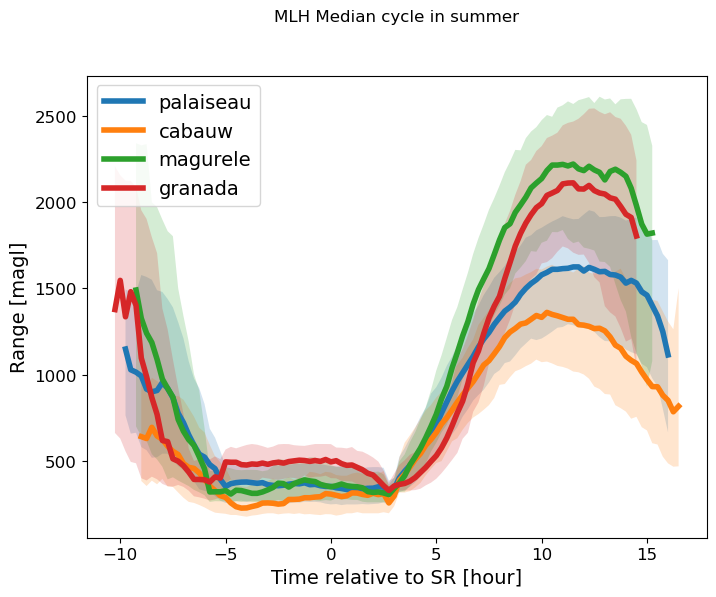

In [6]:
## -------- Plot MLH median cycles ----------
fig = plt.figure(figsize=(8, 6))

plt.title("MLH Median cycle in summer",  y=1.1)
lim = 100
for site in sites :
    df = dict_MLH[f"MLH_{site}_jja"].copy()
    plt.plot(df.time_relSR[df.nsamples > lim], df.mlh[df.nsamples > lim], label=f'{site}', linewidth = 4)
    plt.fill_between(df[df.nsamples > lim].time_relSR, df[df.nsamples > lim].q3, df[df.nsamples > lim].q1, alpha=0.2)

plt.xlabel("Time relative to SR [hour]",fontsize=14)
plt.ylabel("Range [magl]", fontsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=14, loc="upper left")


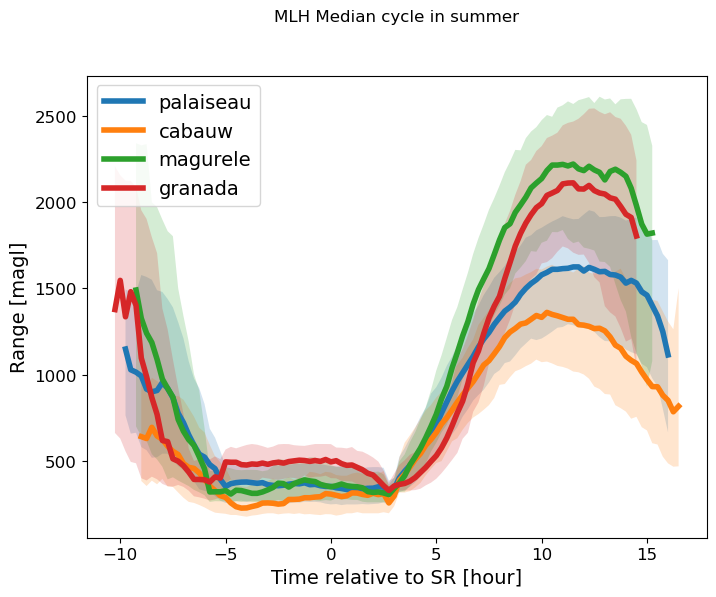

In [7]:

## -------- Plot MLH median cycles ----------
fig = plt.figure(figsize=(8, 6))

plt.title("MLH Median cycle in summer",  y=1.1)
lim = 100
for site in sites :
    df = dict_MLH[f"MLH_{site}_jja"].copy()
    plt.plot(df.time_relSR[df.nsamples > lim], df.mlh[df.nsamples > lim], label=f'{site}', linewidth = 4)
    plt.fill_between(df[df.nsamples > lim].time_relSR, df[df.nsamples > lim].q3, df[df.nsamples > lim].q1, alpha=0.2)

plt.xlabel("Time relative to SR [hour]",fontsize=14)
plt.ylabel("Range [magl]", fontsize=14)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.legend(fontsize=14, loc="upper left")



### Urban site case study : Paris

In [8]:
## --------- Load data in 2022 -----------

MLH_palaiseau = xr.open_mfdataset(f"{path_data}/eprofile_L2B_STRATFINDER_palaiseau_chm15k-B_v01_2022071*.nc").MLH.to_dataframe()
MLH_paris = xr.open_mfdataset(f"{path_data}/eprofile_L2B_STRATFINDER_qualair_chm15k-A_v01_2022071*.nc").MLH.to_dataframe()
MLH_palaiseau = MLH_palaiseau.droplevel("station_name").resample("15min").mean()
MLH_paris = MLH_paris.droplevel("station_name").resample("15min").mean()

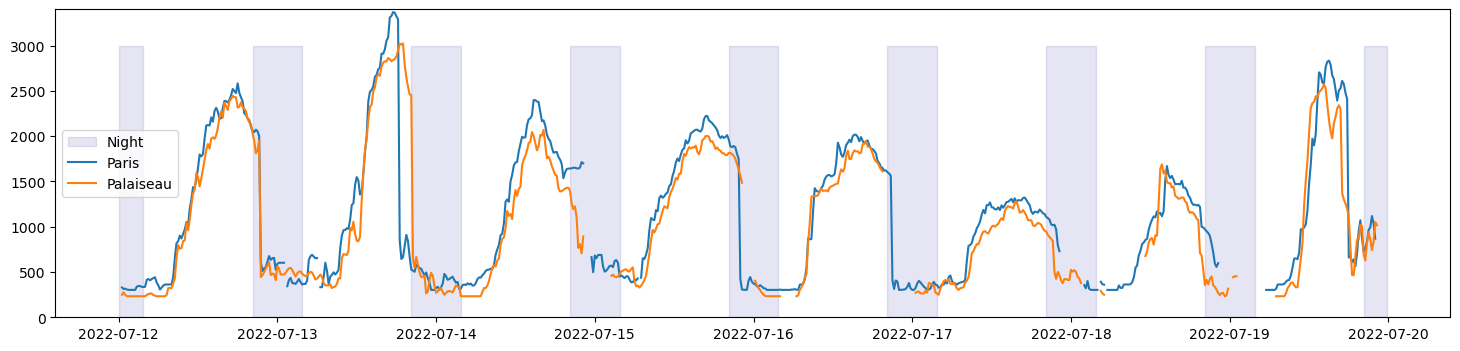

In [9]:
## --------- Plot time serie in summer -------------

df_urban = MLH_paris[MLH_paris.index.date >= date(2022,7,12)]
df_suburban = MLH_palaiseau[MLH_palaiseau.index.date >= date(2022,7,12)]

fig, ax = plt.subplots(figsize=(18, 4)) 

ax.fill_between(df_urban.index, -0, 3000,
                where=((df_urban.index.time < time(4,0,0)) | (df_urban.index.time > time(20,0,0))), alpha=0.1, color='darkblue',
                label='Night')
ax.set_ylim([0,3400])

ax.plot(df_urban.MLH, label = "Paris")
ax.plot(df_suburban.MLH, label = "Palaiseau")

plt.legend()

### Urban site case study : Cabauw 
Cabauw is a rural zone located at ~20km of Rotterdam 
Both are in a marine climate

In [10]:
## ----------- Load data ----------------

signal_cabauw = xr.open_dataset(f"{path_data}/eprofile_BSC_STRATFINDER_cabauw_chm15k-A_v01_20220811.nc").beta.to_dataframe()
signal_rotterdam = xr.open_dataset(f"{path_data}/eprofile_BSC_STRATFINDER_rotterdam_chm15k-Y_v01_20220811.nc").beta.to_dataframe()
MLH_cabauw = xr.open_dataset(f"{path_data}/eprofile_L2B_STRATFINDER_cabauw_chm15k-A_v01_20220811.nc").MLH.to_dataframe()
MLH_rotterdam = xr.open_dataset(f"{path_data}/eprofile_L2B_STRATFINDER_rotterdam_chm15k-Y_v01_20220811.nc").MLH.to_dataframe()

In [11]:
## ---------- Make data easier to handle ---------

pivot_signal_cabauw = from_df_to_pivot(signal_cabauw, "beta", 1)
pivot_signal_rotterdam = from_df_to_pivot(signal_rotterdam, "beta", 1)

MLH_cabauw = MLH_cabauw.droplevel("station_name").resample("15min").mean()
MLH_rotterdam = MLH_rotterdam.droplevel("station_name").resample("15min").mean()

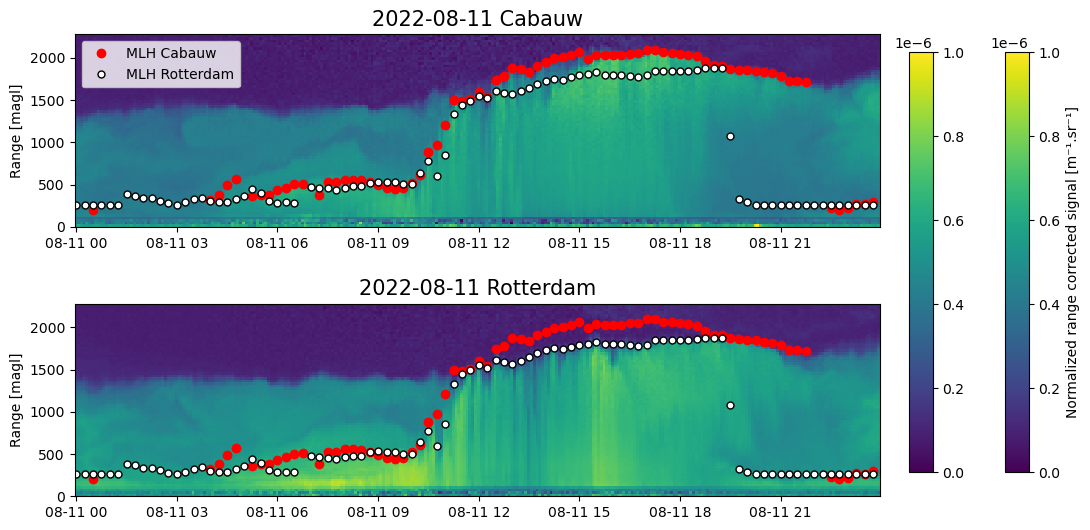

In [12]:
## ----------- Plot attenuated backscatter signal & MLH ---------------

date_ = date(2022, 8, 11)
field1 = pivot_signal_cabauw
field2 = pivot_signal_rotterdam
site1 = "Cabauw"
site2 = "Rotterdam"

data = {
    "MLH_Cabauw": list(MLH_cabauw.MLH),
    "MLH_Rotterdam": list(MLH_rotterdam.MLH),
}

df = pd.DataFrame(data, index = MLH_rotterdam.index)

vmin1 = 0
vmin2 = 0
vmax1 = 1 * 10**-6
vmax2 = 1 * 10**-6

plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 1, 0, "viridis")

## Doppler Wind Lidar (DWL) VS CL61
Comparison between two methods

DWL => variance of the vertical velocity of the wind

CL61 => attenuated backscatter signal

In [13]:
#
## ------------- load MLH data --------------
MLH_ws400_flag = pd.read_csv("/home/mvanhove/WIND_LIDARS/W400S/MLH/MLH_ws400_2022_flag_rain.csv")
MLH_ws400_flag = MLH_ws400_flag.set_index("time")
MLH_ws400_flag.index = pd.to_datetime(MLH_ws400_flag.index)
MLH_ws400_flag = MLH_ws400_flag.MLH

## ------------- load variance data ------------
variance_field = xr.open_dataset("/homedata/mvanhove/SIGMA_W/data_20220702_test.nc").sigma_w.to_dataframe()
variance_field = variance_field[~variance_field.index.duplicated(keep='first')]
pivot_variance_field = from_df_to_pivot(variance_field, "sigma_w", 0)

FileNotFoundError: [Errno 2] No such file or directory: '/home/mvanhove/WIND_LIDARS/W400S/MLH/MLH_ws400_2022_flag_rain.csv'

In [ ]:
#
date_ = date(2022, 7, 2)
field1 = pivot_variance_field
field2 = pivot_L1_CL61 
site1 = "DWL"
site2 = "CL61"
MLH_ws400_flag = MLH_ws400_flag[MLH_ws400_flag.index.date == date_]

data = {
    f"MLH_{site1}": list(MLH_ws400_flag),
    f"MLH_{site2}": list(MLH_CL61.MLH),
}

df = pd.DataFrame(data, index = MLH_CL61.index)

vmin1 = 0
vmin2 = 0
vmax1 = 1 * 10**0
vmax2 = 1 * 10**-6

plot_MLH(date_, field1, field2, site1, site2, df, vmin1, vmin2, vmax1, vmax2, 1, 0, "magma")

#
The turbulence-derived MLH from DWL observations appears to rise slightly earlier in the morning that the aerosol-based layer height on some case study days. 

This has also been found in the literature (e.g. Kotthaus et al. 2018).

